In [25]:
import importlib
import sys, getopt
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
sys.path.append('../neural_networks/mnist_wgan')
import wganDiscriminator

In [44]:
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255 #pixel values in [0,1]
#print(img_data.shape)
test_data = x_test.copy()
test_data = test_data.reshape(x_test.shape[0], 28, 28, 1)
test_data = test_data / 255
#print(test_data.shape)
y_test_one_hot = np.eye(10)[y_test]

In [26]:
# load gan
discriminator = wganDiscriminator.WganDiscriminator()
#genPath = "./wGan_1000_epochs/wgan_generator.h5"
discPath = "../neural_networks/mnist_wgan/wGan_1000_epochs/wgan_discriminator.h5"
#invPath = "./wGan_1000_epochs/wgan_inverter.h5"
discriminator.load_discriminator(discPath)

In [52]:
x_test_batch = tf.Variable(tf.cast(test_data, tf.float32))
disc_output = discriminator.discriminator(x_test_batch)
threshold = tf.reduce_max(disc_output).numpy()
print(threshold)

0.1243498


In [27]:
blank_img = np.zeros(shape = (28, 28))
blank_img = np.expand_dims(blank_img, -1)
blank_img = np.expand_dims(blank_img, 0)
x_blank = tf.Variable(tf.cast(blank_img, tf.float32))
pred_blank = discriminator.discriminator(x_blank)
pred_blank_prob = tf.math.sigmoid(pred_blank)
print(pred_blank)

tf.Tensor([0.05829325], shape=(1,), dtype=float32)


In [28]:
rand_img = np.random.uniform(0,1,(28,28))
rand_img = np.expand_dims(rand_img, -1)
rand_img = np.expand_dims(rand_img, 0)
x_rand = tf.Variable(tf.cast(rand_img, tf.float32))
pred_rand = discriminator.discriminator(x_rand)
pred_rand_prob = tf.math.sigmoid(pred_rand)
print(pred_rand)

tf.Tensor([-0.7413522], shape=(1,), dtype=float32)


In [57]:
def maxDisc(x):
    endCond = False
    iter = 0
    maxIter = 1000
    epsilon = 0.1
    while(not endCond and iter < maxIter):
        with tf.GradientTape() as tape:
            result = discriminator.discriminator(x)
        grad = tape.gradient(result, x)
        x.assign(x + epsilon * grad)
        x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
        iter += 1
        #pred_temp = tf.math.sigmoid(discriminator.discriminator(x))
        pred_temp = discriminator.discriminator(x)
        if(iter % 100 == 0):
            print(iter)
            print(pred_temp)
        if(pred_temp >= 0.99*threshold):
            endCond = True

In [58]:
x_blank_hat = tf.Variable(tf.identity(x_blank))
x_rand_hat = tf.Variable(tf.identity(x_rand))

In [59]:
maxDisc(x_blank_hat)
maxDisc(x_rand_hat)

100
tf.Tensor([0.10238427], shape=(1,), dtype=float32)
100
tf.Tensor([-0.42184895], shape=(1,), dtype=float32)
200
tf.Tensor([-0.19458523], shape=(1,), dtype=float32)
300
tf.Tensor([-0.02662325], shape=(1,), dtype=float32)
400
tf.Tensor([0.07993555], shape=(1,), dtype=float32)


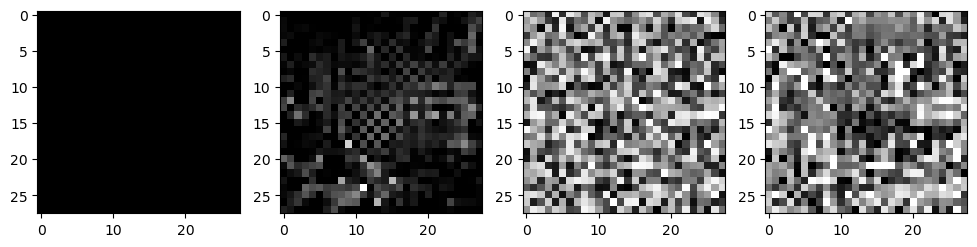

In [63]:
fig, ax = plt.subplots(1,4, figsize=(12,8))
ax[0].imshow(x_blank[0,:,:,0], cmap = 'gray', interpolation = 'none')
ax[1].imshow(x_blank_hat[0,:,:,0], cmap = 'gray', interpolation = 'none')
ax[2].imshow(x_rand[0,:,:,0], cmap = 'gray', interpolation = 'none')
ax[3].imshow(x_rand_hat[0,:,:,0], cmap = 'gray', interpolation = 'none')
plt.savefig("DiscMaximization")